## Setting the environment

In [77]:
# Importing essential libraries and functions

import pandas as pd
import numpy as np
import re
import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from numpy import array

import tensorflow
from tensorflow import keras
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from tensorflow.keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from tensorflow.keras.layers import Embedding, SpatialDropout1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, MaxPooling1D
import matplotlib.pyplot as plt
from keras.layers import Conv1D


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\salma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Loading DataSet

In [82]:
reviews_data = pd.read_csv("corrected_reviews.csv")
reviews_data.shape

(11639, 3)

In [83]:
reviews_data.head(5)

,Sentiments,Reviews,language
0,1,great original product great discount,en
1,0,trouser stuff good shirt poor quality,en
2,0,not leather jacket magazine quality not per de...,en
3,1,picture really good fabric received earlier gi...,en
4,0,fragrance short shelf life months started deve...,en


In [84]:
reviews_data = reviews_data.dropna(subset=['Reviews'])
# Checking for missing values

reviews_data.isnull().values.any()

False

<Axes: xlabel='Sentiments', ylabel='count'>

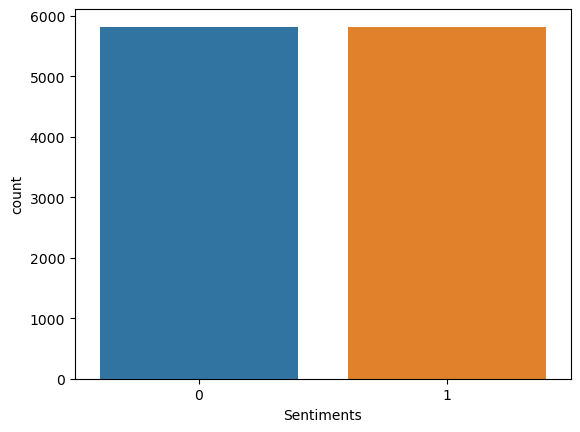

In [85]:
# Let's observe distribution of positive / negative sentiments in dataset

import seaborn as sns
sns.countplot(x='Sentiments', data=reviews_data)

## Data Preprocessing

In [86]:
reviews_data["Reviews"][100]
# You can see that our text contains punctuations, brackets and numbers

'nice accessory pad pro honestly can without personally not going use much thought would not see use not artist something honest pen galaxy note amazing apple pencil honest opinion get use tireless magnetic keyboard came pad pro case pencil sending mine back getting refund'

In [87]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [88]:
#"not" plays an important role on reviews
contractions_dict = {
    r"don't": "do not",
    r"doesn't": "does not",
    r"didn't": "did not",
    r"haven't": "have not",
    r"hasn't": "has not",
    r"hadn't": "had not",
    r"won't": "will not",
    r"wouldn't": "would not",
    r"couldn't": "could not",
    r"shouldn't": "should not",
    r"mightn't": "might not",
    r"mustn't": "must not",
    r"weren't": "were not",
    r"wasn't": "was not",
    r"ain't": "is not",
    r"won't": "would not"
}
def expand_contractions(text):
    for contraction, expanded_form in contractions_dict.items():
        text = re.sub(contraction, expanded_form, text, flags=re.IGNORECASE)
    return text

In [89]:
def preprocess_text(text):
     # Remove html tags
    text = remove_tags(text)

    #expanded forms
    text = expand_contractions(text)
    # Tokenization
    tokens = word_tokenize(text)
    
    # Text Normalization
    tokens = [token.lower() for token in tokens]  # convert to lowercase
    tokens = [token for token in tokens if token.isalpha()]  # remove punctuation and numbers

    # Stopword Removal
    stop_words = set(stopwords.words('english'))
    stop_words.remove('not')
    tokens = [token for token in tokens if token not in stop_words]
    
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]  # lemmatization

    text = ' '.join(tokens)

    return text


reviews_data['Reviews'] = reviews_data['Reviews'].apply(preprocess_text)

In [90]:
reviews_data["Reviews"][100]

'nice accessory pad pro honestly without personally not going use much thought would not see use not artist something honest pen galaxy note amazing apple pencil honest opinion get use tireless magnetic keyboard came pad pro case pencil sending mine back getting refund'

In [91]:
reviews_data

,Sentiments,Reviews,language
0,1,great original product great discount,en
1,0,trouser stuff good shirt poor quality,en
2,0,not leather jacket magazine quality not per de...,en
3,1,picture really good fabric received earlier gi...,en
4,0,fragrance short shelf life month started devel...,en
...,...,...,...
11634,0,connected motordata pp year subscription carsc...,en
11635,1,ana best quality dismounted product excellent ...,en
11636,1,good quality one important thing want buy go b...,en
11637,1,useful storage,en


In [92]:
X_train, X_test, y_train, y_test = train_test_split(reviews_data["Reviews"],reviews_data["Sentiments"], test_size=0.20, random_state=42)

## Preparing Input layer

Let's now write the script for our embedding layer. Embedding layer converts our textual data into numeric form. It is then **used as the first layer for the deep learning models in Keras**.

In [93]:
# Embedding layer expects the words to be in numeric form 
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer 
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [94]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

5169

In [95]:
# Padding all reviews to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [96]:
def create_embedding_matrix(file_path, word_index, embedding_dim):
    # Step 6: Vocabulary size
    vocab_size = len(word_index) + 1
    
    # Step 8: Initialize the embedding matrix with zeros
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    
    # Step 10: Open the embedding file
    with open(file_path, encoding='utf-8') as file:
        for line in file:
            # Step 13: Extract the word and its corresponding vector
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            
            # Step 15: If the word is in word_index
            if word in word_index:
                # Step 17: Get the word index
                idx = word_index[word]
                
                # Step 19: Extract the embedding vector
                embedding_matrix[idx] = vector[:embedding_dim]
    
    # Step 22: Return the embedding matrix
    return embedding_matrix

file_path = 'a2_glove.6B.100d.txt' 
embedding_dim = 100

embedding_matrix = create_embedding_matrix(file_path, word_tokenizer.word_index, embedding_dim)

In [97]:
embedding_matrix.shape

(5169, 100)

# Model Training with:

## Randoem Forest Classifier

In [98]:
from sklearn.ensemble import RandomForestClassifier


model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)

RandomForestClassifier()

Training Accuracy : 0.9981740064446831
Testing Accuracy : 0.7920962199312714


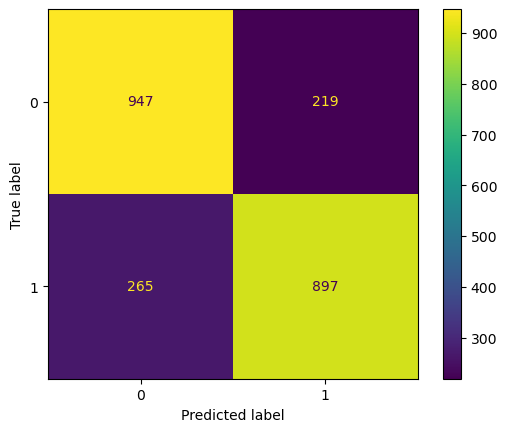

In [99]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
print("Training Accuracy :", model_rf.score(X_train, y_train))
print("Testing Accuracy :", model_rf.score(X_test, y_test))
y_preds = model_rf.predict(X_test)
cm = confusion_matrix(y_test, y_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

## Simple Neural Network

In [104]:
# Neural Network architecture

snn_model = Sequential()
embedding_layer = Embedding(vocab_length, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=False)

snn_model.add(embedding_layer)

snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

In [105]:
# Model compiling

snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(snn_model.summary())

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_18 (Embedding)        │ ?                      │       516,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 516,900 (1.97 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 516,900 (1.97 MB)

None


In [106]:
# Model training

snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=6, validation_split=0.2)

Epoch 1/6
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - acc: 0.6678 - loss: 0.6133 - val_acc: 0.8099 - val_loss: 0.4778
Epoch 2/6
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.8253 - loss: 0.4533 - val_acc: 0.8319 - val_loss: 0.4207
Epoch 3/6
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.8550 - loss: 0.3941 - val_acc: 0.8523 - val_loss: 0.3853
Epoch 4/6
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.8646 - loss: 0.3617 - val_acc: 0.8614 - val_loss: 0.3713
Epoch 5/6
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8765 - loss: 0.3390 - val_acc: 0.8614 - val_loss: 0.3611
Epoch 6/6
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.8788 - loss: 0.3250 - val_acc: 0.8647 - val_loss: 0.3526


In [107]:
# Predictions on the Test Set

score = snn_model.evaluate(X_test, y_test)

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.8369 - loss: 0.3836


In [108]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3744269609451294
Test Accuracy: 0.8513745665550232


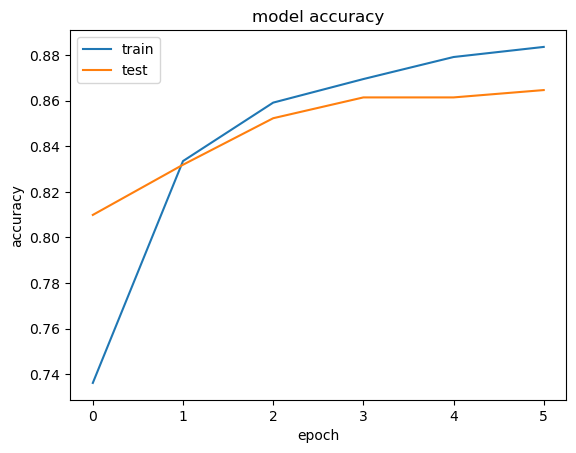

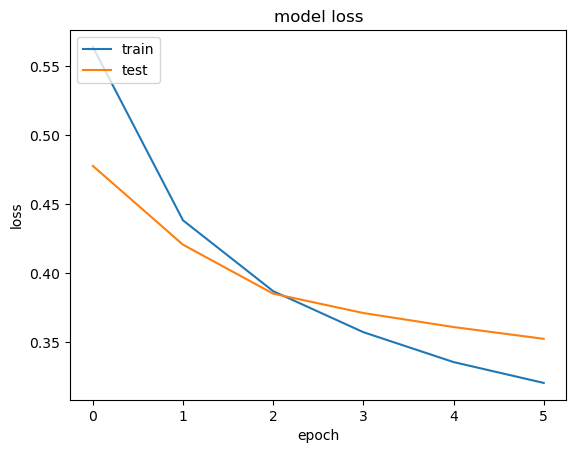

In [109]:
# Model Performance Charts

plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Convolutional Neural Network

In [110]:
# Neural Network architecture

cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [111]:
# Model compiling

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_19 (Embedding)        │ ?                      │       516,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_3          │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 516,900 (1.97 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 516,900 (1.97 MB)

None


In [112]:
# Model training

cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=10, validation_split=0.2)

Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - acc: 0.7714 - loss: 0.4835 - val_acc: 0.8802 - val_loss: 0.3010
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - acc: 0.9008 - loss: 0.2642 - val_acc: 0.8931 - val_loss: 0.2685
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - acc: 0.9240 - loss: 0.2142 - val_acc: 0.8942 - val_loss: 0.2535
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - acc: 0.9398 - loss: 0.1787 - val_acc: 0.8990 - val_loss: 0.2454
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - acc: 0.9543 - loss: 0.1471 - val_acc: 0.9006 - val_loss: 0.2460
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - acc: 0.9580 - loss: 0.1329 - val_acc: 0.9055 - val_loss: 0.2478
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - acc: 0.9677 - loss: 0.1178 - val_acc: 0.9044 - val_loss: 0.2444
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - acc: 0.9770 - loss: 0.0919 - val_acc: 0.9023 - val_loss: 0.2436
Epoch 9/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - acc: 0.9820

In [113]:
# Predictions on the Test Set

score = cnn_model.evaluate(X_test, y_test)

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.9017 - loss: 0.2664


In [114]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.26305797696113586
Test Accuracy: 0.9037800431251526


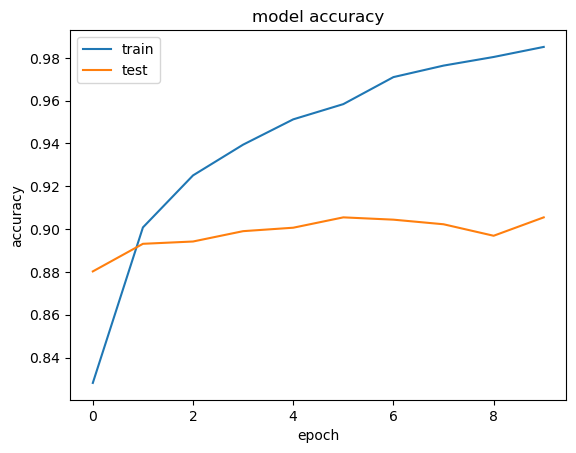

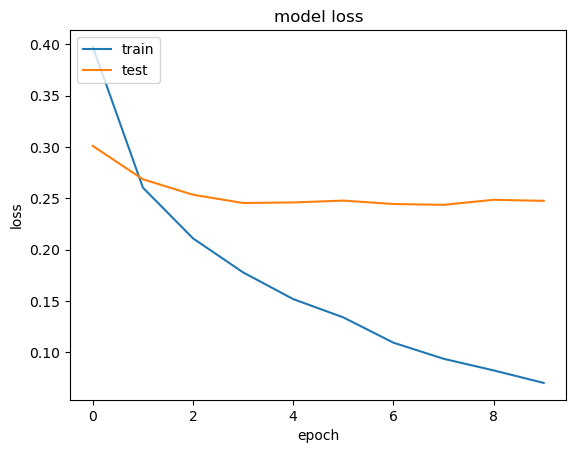

In [115]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

## RNN Neural Network (LSTM)

In [116]:
lstm_units = 128
dropout = 0.2
from tensorflow import keras
model = Sequential()
model.add(Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False))
model.add(Dropout(dropout))

model.add(Bidirectional(LSTM(lstm_units, return_sequences=True)))
model.add(Dropout(dropout))

model.add(Bidirectional(LSTM(lstm_units)))
model.add(Dropout(dropout))

model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train model
rnn_model_history = model.fit(X_train, y_train, batch_size=128, epochs=10, validation_split=0.2, callbacks=[early_stopping])

# Evaluate model
score = model.evaluate(X_test, y_test)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 43s 581ms/step - accuracy: 0.7703 - loss: 0.4912 - val_accuracy: 0.8926 - val_loss: 0.2836
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 34s 582ms/step - accuracy: 0.8825 - loss: 0.3023 - val_accuracy: 0.9012 - val_loss: 0.2640
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 34s 569ms/step - accuracy: 0.8880 - loss: 0.2878 - val_accuracy: 0.9001 - val_loss: 0.2560
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 37s 623ms/step - accuracy: 0.8955 - loss: 0.2644 - val_accuracy: 0.8921 - val_loss: 0.2744
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 35s 601ms/step - accuracy: 0.8907 - loss: 0.2697 - val_accuracy: 0.9017 - val_loss: 0.2528
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 37s 623ms/step - accuracy: 0.9004 - loss: 0.2452 - val_accuracy: 0.9082 - val_loss: 0.2377
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 35s 596ms/step - accuracy: 0.9045 - loss: 0.2410 - val_accuracy: 0.9039 - val_loss: 0.2477
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 35s 591ms/step - accuracy: 0.9073 - loss: 0.2380 - val_accu

In [117]:

model2 = Sequential()
model2.add(Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen, trainable=True))
model2.add(Dropout(dropout))

model2.add(Bidirectional(LSTM(lstm_units, return_sequences=True)))
model2.add(Dropout(dropout))

model2.add(Bidirectional(LSTM(lstm_units)))
model2.add(Dropout(dropout))

model2.add(Dense(64, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

# Compile model
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train model
rnn_model_history = model2.fit(X_train, y_train, batch_size=128, epochs=10, validation_split=0.2, callbacks=[early_stopping])

# Evaluate model
score = model2.evaluate(X_test, y_test)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Epoch 1/10


d:\anaconda\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


59/59 ━━━━━━━━━━━━━━━━━━━━ 51s 684ms/step - accuracy: 0.7366 - loss: 0.5074 - val_accuracy: 0.8958 - val_loss: 0.2590
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 39s 662ms/step - accuracy: 0.8971 - loss: 0.2664 - val_accuracy: 0.9060 - val_loss: 0.2410
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 42s 720ms/step - accuracy: 0.9108 - loss: 0.2314 - val_accuracy: 0.9157 - val_loss: 0.2204
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 42s 719ms/step - accuracy: 0.9274 - loss: 0.1946 - val_accuracy: 0.9205 - val_loss: 0.2090
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 43s 724ms/step - accuracy: 0.9334 - loss: 0.1769 - val_accuracy: 0.9194 - val_loss: 0.2020
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 42s 714ms/step - accuracy: 0.9373 - loss: 0.1729 - val_accuracy: 0.9232 - val_loss: 0.1977
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 43s 729ms/step - accuracy: 0.9457 - loss: 0.1495 - val_accuracy: 0.9168 - val_loss: 0.2321
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 43s 730ms/step - accuracy: 0.9506 - loss: 0.1403 - val_accuracy: 0.916

## saving model

In [160]:
import pickle
model2.save('lstm_model.keras')

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(word_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step


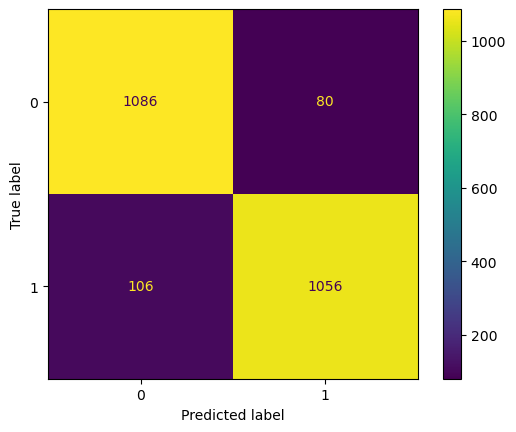

In [159]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_preds = model2.predict(X_test)
for i in range(len(y_preds)):
    if y_preds[i] > 0.5:
        y_preds[i] = 1
    else:
         y_preds[i] = 0
cm = confusion_matrix(y_test, y_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

In [154]:
from textblob import TextBlob
# Function to correct spelling errors using TextBlob
def correct_spelling(text):
    blob = TextBlob(text)
    corrected_text = str(blob.correct())
    return corrected_text

def predict_sentiment(review):
    corrected = correct_spelling(review)
    review = preprocess_text(corrected)
    tokenized = word_tokenizer.texts_to_sequences([review])
    paddded = pad_sequences(tokenized, padding='post', maxlen=100)
    score = model2.predict(paddded)
    return "positive" if score > 0.5 else "negative"

In [156]:
my_review = "the product was not very gooddd"
predict_sentiment(my_review)

product not good
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


'negative'

In [33]:
negative_reviews = [review for review in reviews_data[reviews_data['Sentiments'] == 0]['Reviews']]
negative_reviews

['trouser stuff good shirt poor quality',
 'not leather jacket magazine quality not per description ',
 'fragrance short shelf life months started develop unpleasant rapid smell disappointing invest fragrance go bad quickly expected better quality longevity ',
 'satisfied product good quality product',
 'look ordered received ',
 'good delivery time pages book not good quality fulfill purpose ',
 'ordered two size instead got one smaller size material used good belt fit well hence giving star rating ',
 'poor installation',
 'purchased football two days aback item seems detective press ball passes air solve although no return solve forwarded query instant chat even call tender phone number mentioned receipt nobody responded finally going return product ',
 'first box not come plastic pencil tip yellowish bent side connect pad not work can believe bought face apple product ',
 'received damaged would not connect charge complete rip apple would not replace aerial number would not come ac

In [34]:
negative_reviews_df = pd.DataFrame(negative_reviews, columns=['Review'])
negative_reviews_df

,Review
0,trouser stuff good shirt poor quality
1,not leather jacket magazine quality not per de...
2,fragrance short shelf life months started deve...
3,satisfied product good quality product
4,look ordered received
...,...
5813,pencil stopped charging stopped working right ...
5814,good quality touch material watch however show...
5815,ok not much ok ok sound good need improve pack...
5816,packing not fine


In [35]:
departments_keywords = {
    "Customer Service": [
        "service", "support", "customer service", "help", "response", "rude", "behavior", "polite", "agent", "call", "email",
        "assistance", "aid", "care", "courtesy", "treatment", "interaction", "representative", "communication", "reply", "feedback"
    ],
    "Product Quality": [
        "product", "quality", "defective", "broken", "durable", "material", "build", "manufacture", "craftsmanship", "faulty", "not working", "difficult",
        "item", "standard", "wastage","flawed", "damaged", "component", "construction", "production", "workmanship", "malfunctioning", "inoperative", "challenging"
    ],
    "Shipping": [
        "shipping", "delayed", "package", "sealed", "arrived", "late delivery", "courier", "tracking", "shipment", "dispatch", "fast", "slow",
        "delivery", "postponed", "parcel", "wrapped", "received", "carrier", "monitoring", "consignment", "send", "quick"
    ],
    "Technical Support": [
        "technical", "tech support", "IT", "software", "hardware", "bug", "issue", "glitch", "error", "malfunction", "install", "update",
        "technological", "technical assistance", "information technology", "program", "device", "fault", "problem", "flaw", "mistake", "breakdown", "setup", "upgrade"
    ],
    "Marketing": [
        "marketing", "advertising", "promotion", "campaign", "brand", "advertised", "strategy", "market", "target",
        "promotion", "publicity", "advertisement", "drive", "branding", "marketed"
    ],
    "Sales": [
        "sales", "purchase", "buy", "order", "pricing", "discount", "offer", "deal", "cost", "checkout", "price",
        "transactions", "acquisition", "procure", "command", "rate", "reduction", "proposal", "bargain", "expense", "payment", "value"
    ]
}


In [36]:
# Function to assign departments based on keywords
def assign_departments(review):
    assigned_departments = []
    for department, keywords in departments_keywords.items():
        if any(keyword in review.lower() for keyword in keywords):
            assigned_departments.append(department)
    return ', '.join(assigned_departments) if assigned_departments else "General"

In [37]:
negative_reviews_df['Departments'] = negative_reviews_df['Review'].apply(assign_departments)

In [85]:
negative_reviews_df.to_csv("departments.csv")

In [38]:
negative_reviews_df

,Review,Departments
0,trouser stuff good shirt poor quality,Product Quality
1,not leather jacket magazine quality not per de...,Product Quality
2,fragrance short shelf life months started deve...,"Product Quality, Shipping"
3,satisfied product good quality product,Product Quality
4,look ordered received,"Shipping, Sales"
...,...,...
5813,pencil stopped charging stopped working right ...,General
5814,good quality touch material watch however show...,Product Quality
5815,ok not much ok ok sound good need improve pack...,Product Quality
5816,packing not fine,General


In [1]:
pip install TextBlob


   ---------------------------------------- 0.0/626.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/626.3 kB ? eta -:--:--
    --------------------------------------- 10.2/626.3 kB ? eta -:--:--
    --------------------------------------- 10.2/626.3 kB ? eta -:--:--
   - ------------------------------------- 30.7/626.3 kB 163.8 kB/s eta 0:00:04
   - ------------------------------------- 30.7/626.3 kB 163.8 kB/s eta 0:00:04
   --- ----------------------------------- 61.4/626.3 kB 252.2 kB/s eta 0:00:03
   ----- --------------------------------- 92.2/626.3 kB 327.7 kB/s eta 0:00:02
   --------- ---------------------------- 163.8/626.3 kB 492.3 kB/s eta 0:00:01
   ---------- --------------------------- 174.1/626.3 kB 456.4 kB/s eta 0:00:01
   -------------- ----------------------- 245.8/626.3 kB 580.1 kB/s eta 0:00:01
   ----------------- -------------------- 286.7/626.3 kB 632.7 kB/s eta 0:00:01
   ------------------- ------------------ 327.7/626.3 kB 634.9 kB/s eta 0

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...


True